# Data Analysis for CA-SDGNN: Understanding Class Imbalance

This notebook analyzes the Bitcoin Alpha dataset to understand:
- Class distribution and imbalance
- Edge types and patterns
- Network structure
- Temporal patterns (if applicable)
- Data quality issues

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load and Examine the Dataset

In [4]:
# Load the training and test datasets
def load_edgelist(file_path):
    """Load edgelist file and return DataFrame"""
    try:
        # Try different delimiters
        df = pd.read_csv(file_path, sep='\s+', header=None)
        if df.shape[1] == 3:
            df.columns = ['source', 'target', 'weight']
        elif df.shape[1] == 4:
            df.columns = ['source', 'target', 'weight', 'timestamp']
        else:
            print(f"Unexpected number of columns: {df.shape[1]}")
            df.columns = [f'col_{i}' for i in range(df.shape[1])]
        return df
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Load datasets
train_df = load_edgelist('experiment-data/bitcoin_alpha-train-1.edgelist')
test_df = load_edgelist('experiment-data/bitcoin_alpha-test-1.edgelist')

print("Dataset shapes:")
print(f"Training set: {train_df.shape if train_df is not None else 'Failed to load'}")
print(f"Test set: {test_df.shape if test_df is not None else 'Failed to load'}")

if train_df is not None:
    print("\nTraining set preview:")
    print(train_df.head(10))
    print("\nTraining set info:")
    print(train_df.info())

Dataset shapes:
Training set: (19348, 3)
Test set: (4838, 3)

Training set preview:
   source  target  weight
0       0       1       1
1       1       2       1
2       1       3       1
3       1       4       1
4       1       5       1
5       1       6       1
6       1       7       1
7       1       8       1
8       1       9       1
9       1      10       1

Training set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19348 entries, 0 to 19347
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   source  19348 non-null  int64
 1   target  19348 non-null  int64
 2   weight  19348 non-null  int64
dtypes: int64(3)
memory usage: 453.6 KB
None


## 2. Class Distribution Analysis


=== Training Set Class Distribution ===

Class distribution (by weight):
  Weight -1: 1243 edges (6.42%)
  Weight 1: 18105 edges (93.58%)

Imbalance Ratio: 14.57:1


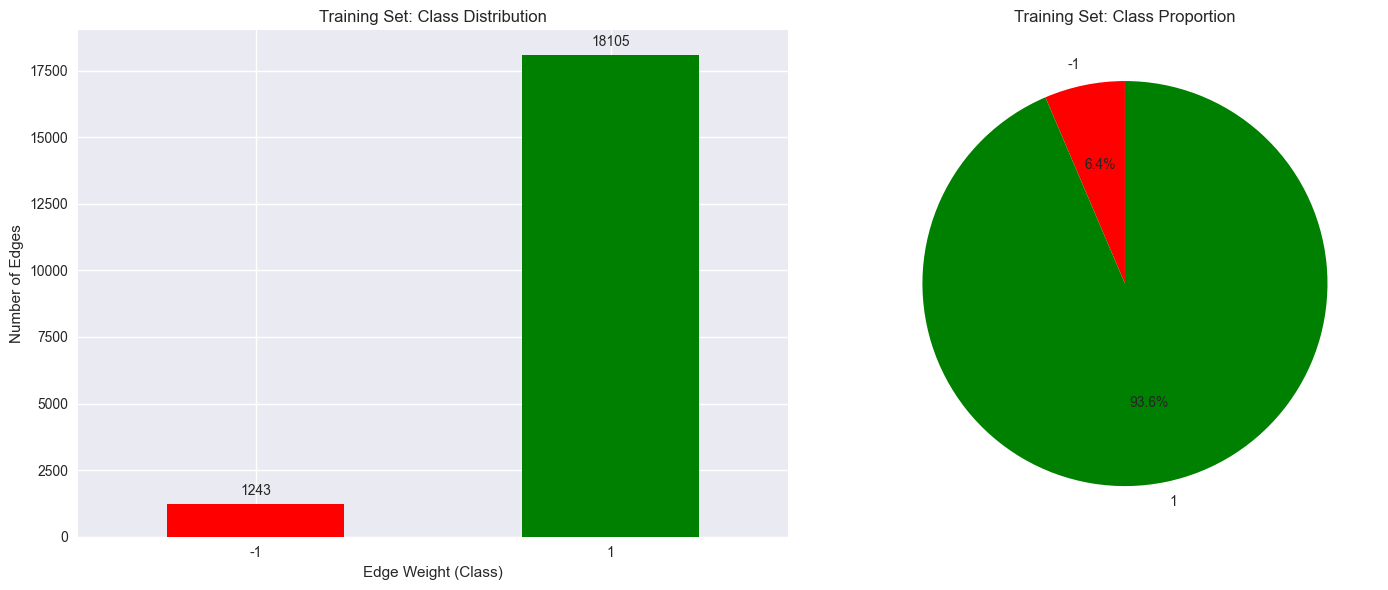


=== Test Set Class Distribution ===

Class distribution (by weight):
  Weight -1: 293 edges (6.06%)
  Weight 1: 4545 edges (93.94%)

Imbalance Ratio: 15.51:1


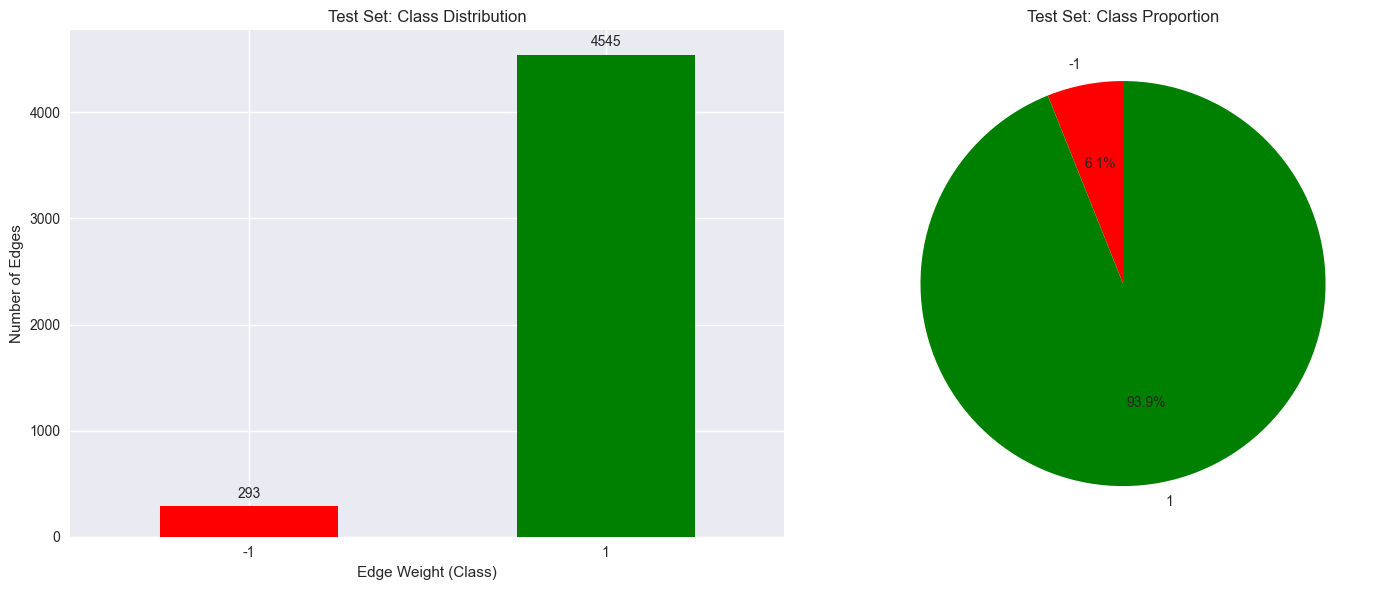

In [5]:
def analyze_class_distribution(df, dataset_name):
    """Analyze and visualize class distribution"""
    if df is None:
        print(f"Cannot analyze {dataset_name} - dataset not loaded")
        return
    
    print(f"\n=== {dataset_name} Class Distribution ===")
    
    # Assuming weight column contains the class labels (positive/negative)
    if 'weight' in df.columns:
        weight_counts = df['weight'].value_counts().sort_index()
        print("\nClass distribution (by weight):")
        for weight, count in weight_counts.items():
            percentage = (count / len(df)) * 100
            print(f"  Weight {weight}: {count} edges ({percentage:.2f}%)")
        
        # Calculate imbalance ratio
        if len(weight_counts) == 2:
            majority_class = weight_counts.max()
            minority_class = weight_counts.min()
            imbalance_ratio = majority_class / minority_class
            print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")
        
        # Visualize distribution
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Bar plot
        weight_counts.plot(kind='bar', ax=ax1, color=['red', 'green'] if len(weight_counts) == 2 else None)
        ax1.set_title(f'{dataset_name}: Class Distribution')
        ax1.set_xlabel('Edge Weight (Class)')
        ax1.set_ylabel('Number of Edges')
        ax1.tick_params(axis='x', rotation=0)
        
        # Add count labels on bars
        for i, v in enumerate(weight_counts.values):
            ax1.text(i, v + len(df)*0.01, str(v), ha='center', va='bottom')
        
        # Pie chart
        colors = ['red', 'green'] if len(weight_counts) == 2 else None
        ax2.pie(weight_counts.values, labels=weight_counts.index, autopct='%1.1f%%', 
                colors=colors, startangle=90)
        ax2.set_title(f'{dataset_name}: Class Proportion')
        
        plt.tight_layout()
        plt.show()
        
        return weight_counts
    else:
        print("No 'weight' column found for class analysis")
        return None

# Analyze both datasets
train_class_dist = analyze_class_distribution(train_df, "Training Set")
test_class_dist = analyze_class_distribution(test_df, "Test Set")

## 3. Network Structure Analysis


=== Training Set Network Structure ===
Number of nodes: 3650
Number of edges: 19348
Density: 0.001453

Degree Statistics:
  Mean degree: 10.60
  Median degree: 3.00
  Max degree: 704
  Min degree: 1


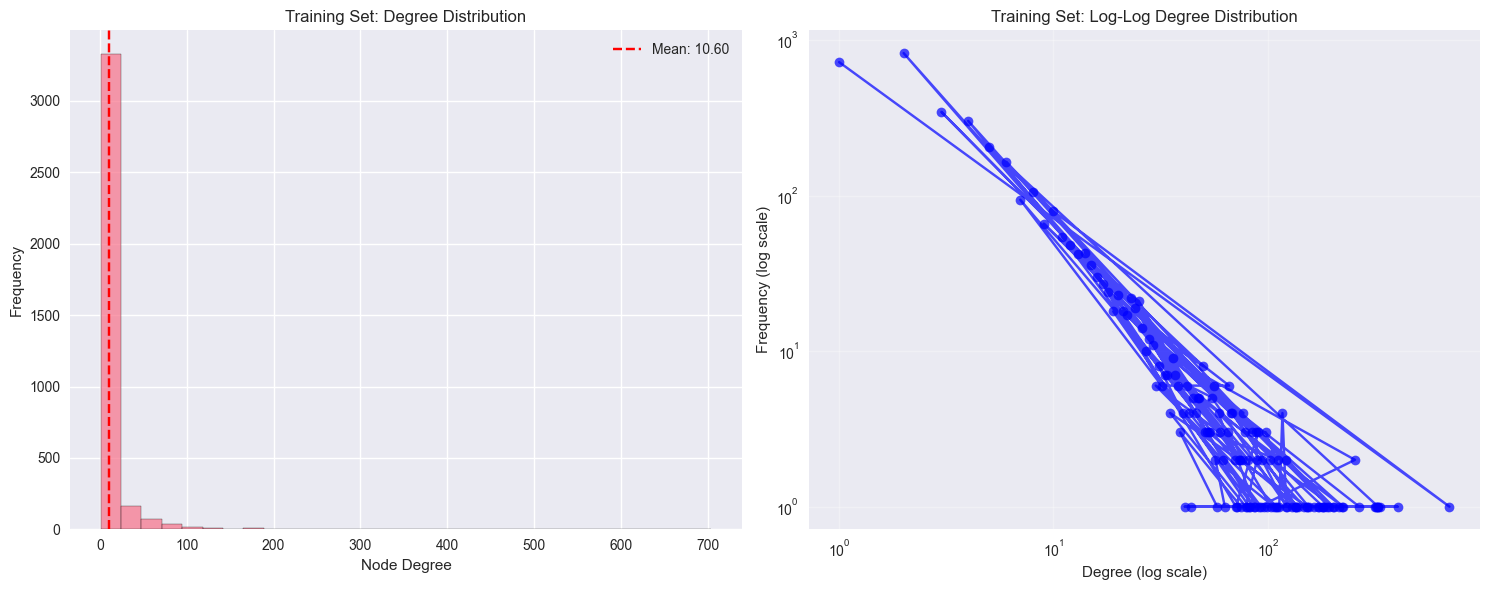


=== Test Set Network Structure ===
Number of nodes: 2333
Number of edges: 4838
Density: 0.000889

Degree Statistics:
  Mean degree: 4.15
  Median degree: 2.00
  Max degree: 184
  Min degree: 1


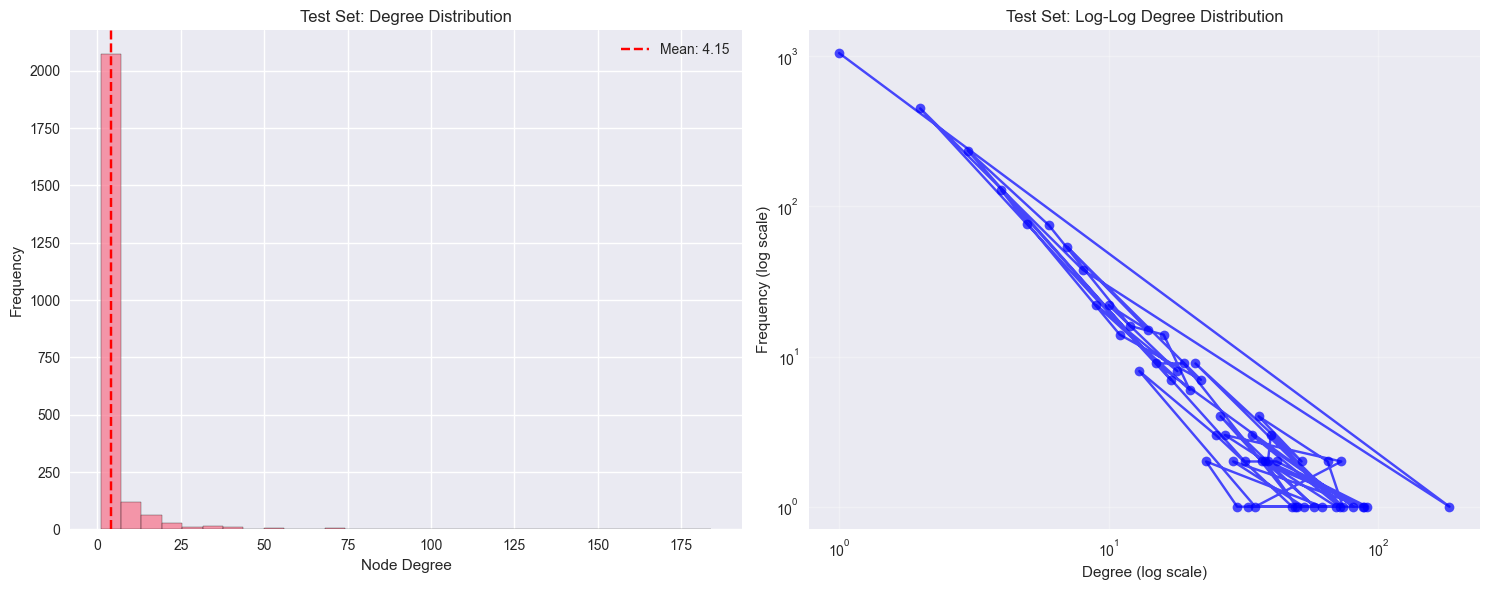

In [6]:
def analyze_network_structure(df, dataset_name):
    """Analyze network structure and properties"""
    if df is None:
        return
    
    print(f"\n=== {dataset_name} Network Structure ===")
    
    # Basic network stats
    unique_nodes = set(df['source']).union(set(df['target']))
    num_nodes = len(unique_nodes)
    num_edges = len(df)
    
    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}")
    print(f"Density: {num_edges / (num_nodes * (num_nodes - 1)):.6f}")
    
    # Node degree analysis
    in_degree = Counter(df['target'])
    out_degree = Counter(df['source'])
    
    # Combine for total degree
    total_degree = Counter()
    for node in unique_nodes:
        total_degree[node] = in_degree.get(node, 0) + out_degree.get(node, 0)
    
    degrees = list(total_degree.values())
    
    print(f"\nDegree Statistics:")
    print(f"  Mean degree: {np.mean(degrees):.2f}")
    print(f"  Median degree: {np.median(degrees):.2f}")
    print(f"  Max degree: {np.max(degrees)}")
    print(f"  Min degree: {np.min(degrees)}")
    
    # Visualize degree distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Degree histogram
    ax1.hist(degrees, bins=30, alpha=0.7, edgecolor='black')
    ax1.set_title(f'{dataset_name}: Degree Distribution')
    ax1.set_xlabel('Node Degree')
    ax1.set_ylabel('Frequency')
    ax1.axvline(np.mean(degrees), color='red', linestyle='--', label=f'Mean: {np.mean(degrees):.2f}')
    ax1.legend()
    
    # Log-log degree distribution
    degree_counts = Counter(degrees)
    x = list(degree_counts.keys())
    y = list(degree_counts.values())
    ax2.loglog(x, y, 'bo-', alpha=0.7)
    ax2.set_title(f'{dataset_name}: Log-Log Degree Distribution')
    ax2.set_xlabel('Degree (log scale)')
    ax2.set_ylabel('Frequency (log scale)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'num_nodes': num_nodes,
        'num_edges': num_edges,
        'degrees': degrees,
        'unique_nodes': unique_nodes
    }

# Analyze network structure
train_network = analyze_network_structure(train_df, "Training Set")
test_network = analyze_network_structure(test_df, "Test Set")

## 4. Edge Weight Distribution Analysis


=== Training Set Edge Weight Analysis ===
Weight statistics:
  Unique weights: [ 1 -1]
  Mean: 0.8715
  Std: 0.4904
  Min: -1
  Max: 1


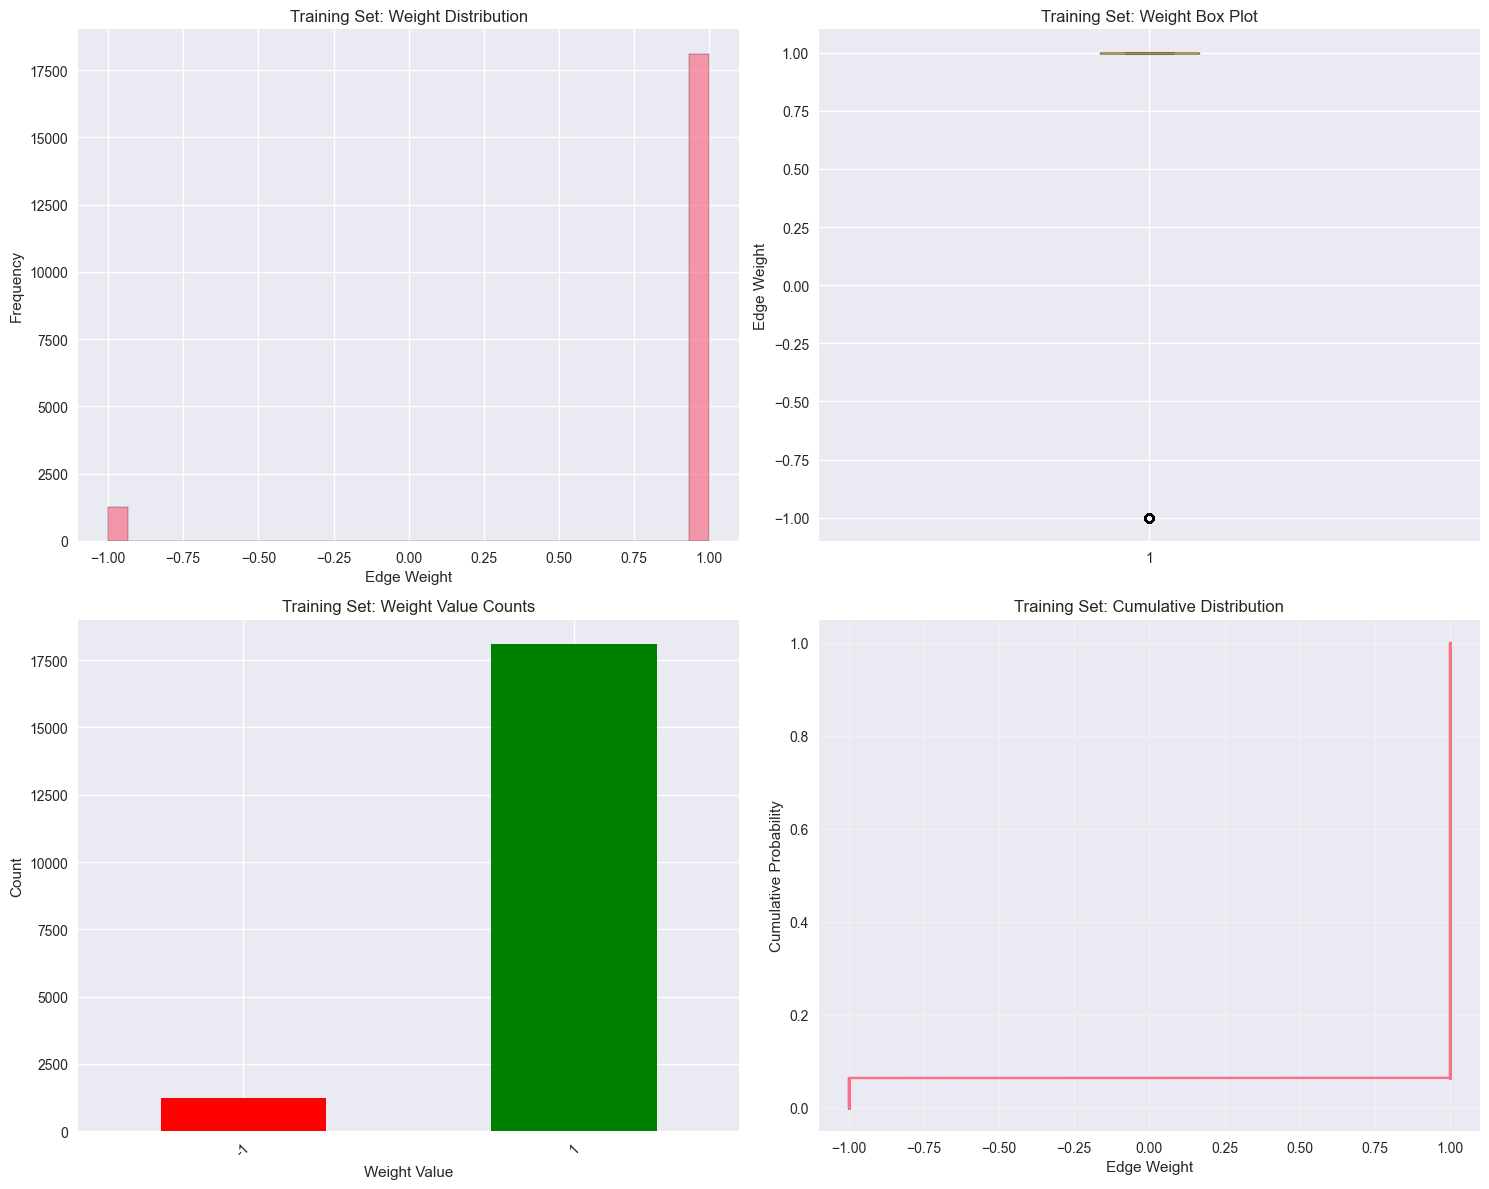


=== Test Set Edge Weight Analysis ===
Weight statistics:
  Unique weights: [ 1 -1]
  Mean: 0.8789
  Std: 0.4771
  Min: -1
  Max: 1


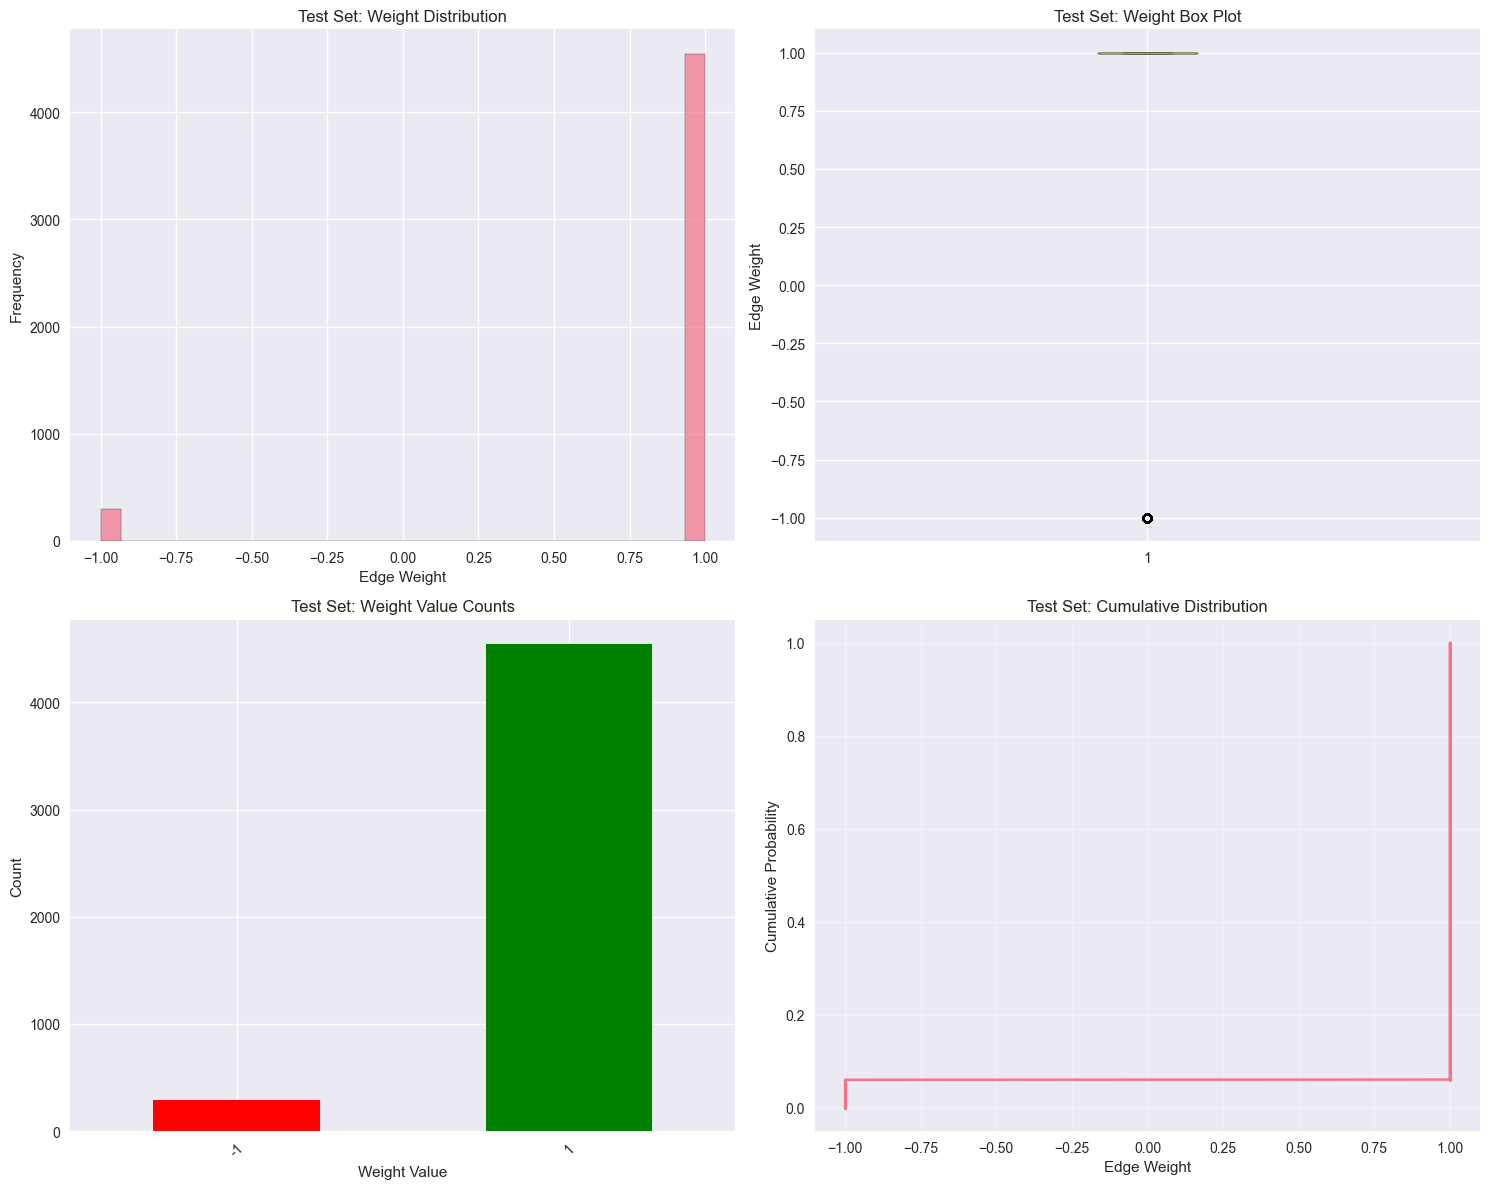

In [8]:
def analyze_edge_weights(df, dataset_name):
    """Detailed analysis of edge weights"""
    if df is None or 'weight' not in df.columns:
        return
    
    print(f"\n=== {dataset_name} Edge Weight Analysis ===")
    
    weights = df['weight']
    
    print(f"Weight statistics:")
    print(f"  Unique weights: {weights.unique()}")
    print(f"  Mean: {weights.mean():.4f}")
    print(f"  Std: {weights.std():.4f}")
    print(f"  Min: {weights.min()}")
    print(f"  Max: {weights.max()}")
    
    # Visualize weight distribution
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Histogram
    axes[0,0].hist(weights, bins=30, alpha=0.7, edgecolor='black')
    axes[0,0].set_title(f'{dataset_name}: Weight Distribution')
    axes[0,0].set_xlabel('Edge Weight')
    axes[0,0].set_ylabel('Frequency')
    
    # Box plot
    axes[0,1].boxplot(weights)
    axes[0,1].set_title(f'{dataset_name}: Weight Box Plot')
    axes[0,1].set_ylabel('Edge Weight')
    
    # Value counts bar plot
    weight_counts = weights.value_counts().sort_index()
    weight_counts.plot(kind='bar', ax=axes[1,0], color=['red' if w < 0 else 'green' for w in weight_counts.index])
    axes[1,0].set_title(f'{dataset_name}: Weight Value Counts')
    axes[1,0].set_xlabel('Weight Value')
    axes[1,0].set_ylabel('Count')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Cumulative distribution
    sorted_weights = np.sort(weights)
    y = np.arange(1, len(sorted_weights) + 1) / len(sorted_weights)
    axes[1,1].plot(sorted_weights, y, marker='o', markersize=2)
    axes[1,1].set_title(f'{dataset_name}: Cumulative Distribution')
    axes[1,1].set_xlabel('Edge Weight')
    axes[1,1].set_ylabel('Cumulative Probability')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return weight_counts

# Analyze edge weights
train_weights = analyze_edge_weights(train_df, "Training Set")
test_weights = analyze_edge_weights(test_df, "Test Set")

## 5. Node Participation Analysis


=== Training Set Node Participation Analysis ===
Nodes in positive edges: 3552
Nodes in negative edges: 754
Nodes in both types: 656
Nodes only in positive: 2896
Nodes only in negative: 98

Node-level positive ratio statistics:
  Mean: 0.9383
  Median: 1.0000
  Std: 0.1910


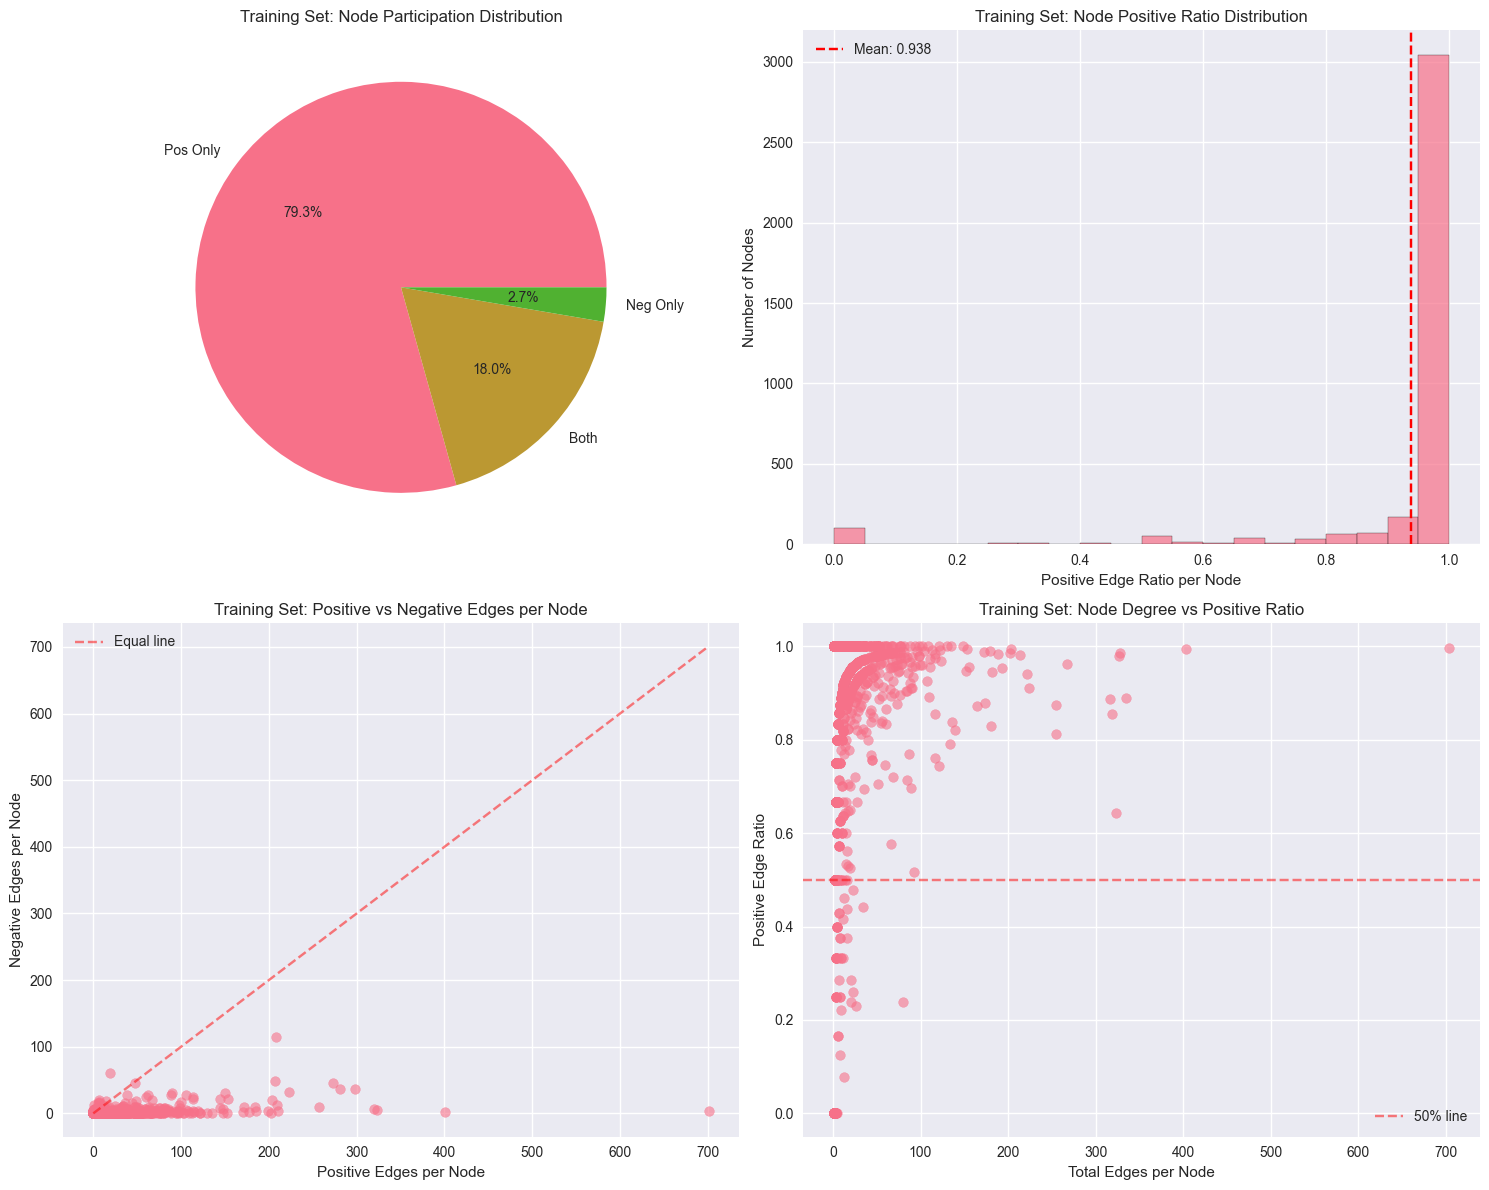


=== Test Set Node Participation Analysis ===
Nodes in positive edges: 2269
Nodes in negative edges: 326
Nodes in both types: 262
Nodes only in positive: 2007
Nodes only in negative: 64

Node-level positive ratio statistics:
  Mean: 0.9438
  Median: 1.0000
  Std: 0.1880


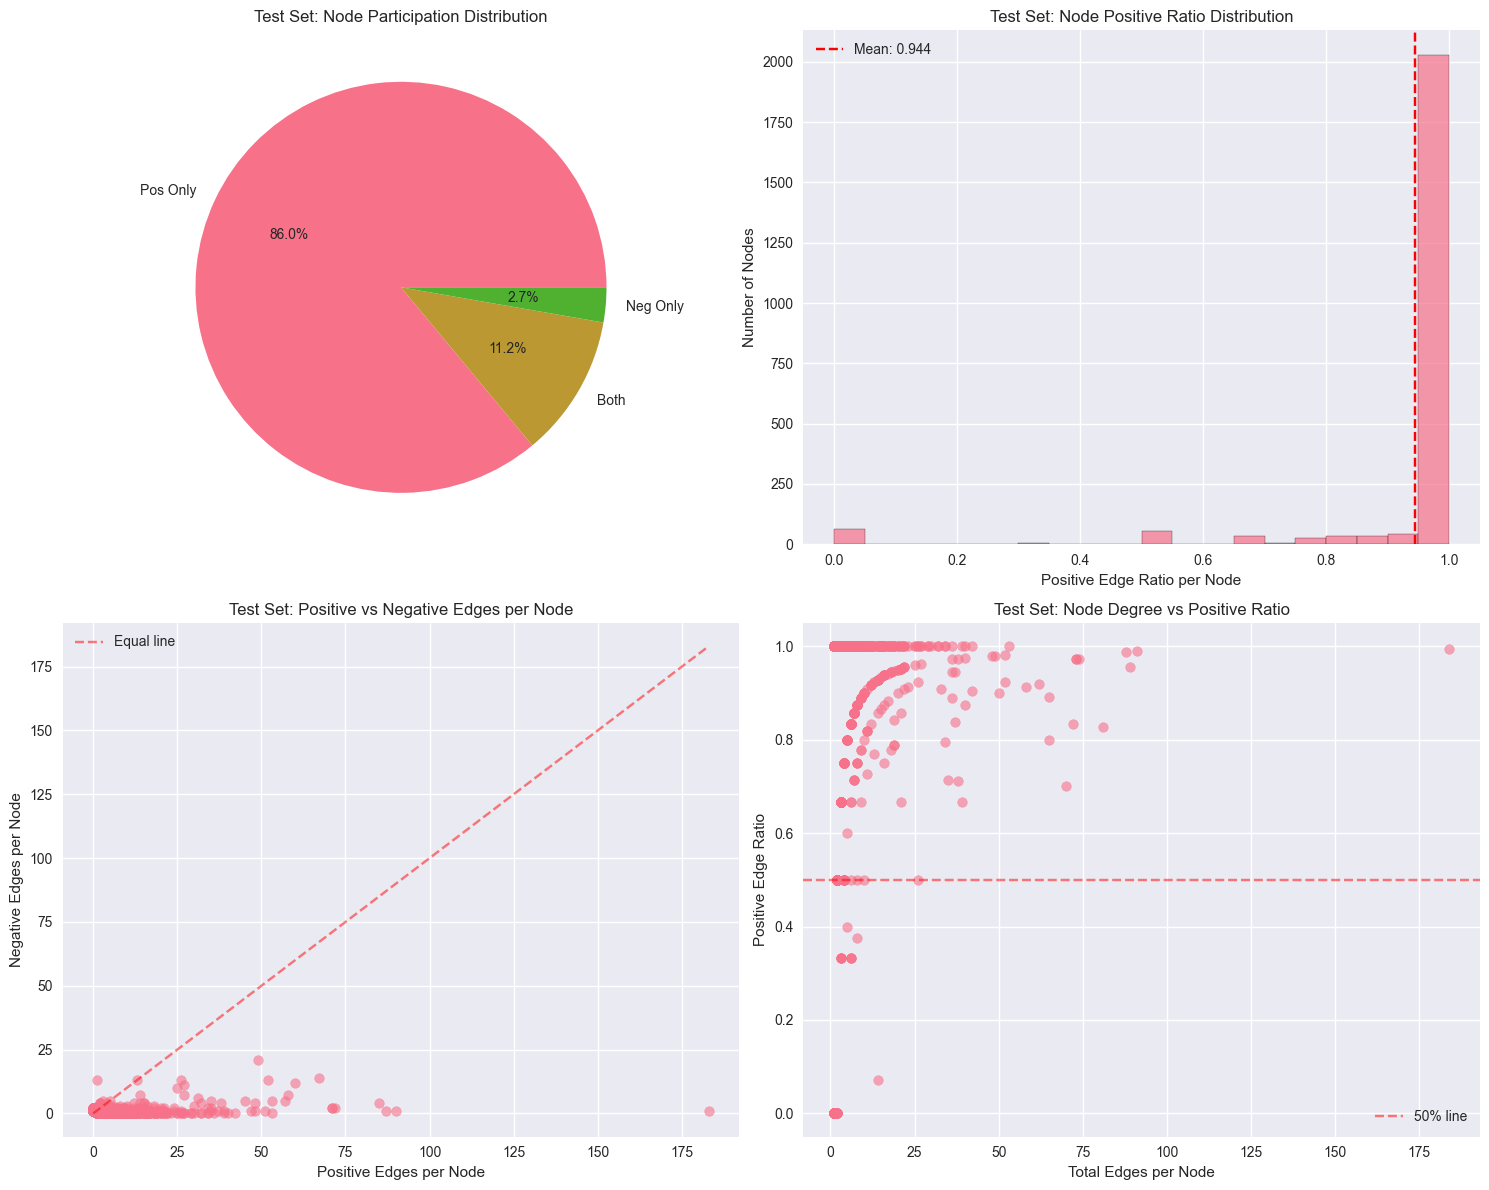

In [9]:
def analyze_node_participation(df, dataset_name):
    """Analyze how nodes participate in positive vs negative edges"""
    if df is None or 'weight' not in df.columns:
        return
    
    print(f"\n=== {dataset_name} Node Participation Analysis ===")
    
    # Separate positive and negative edges
    pos_edges = df[df['weight'] > 0]
    neg_edges = df[df['weight'] < 0]
    
    # Get nodes in positive and negative edges
    pos_nodes = set(pos_edges['source']).union(set(pos_edges['target']))
    neg_nodes = set(neg_edges['source']).union(set(neg_edges['target']))
    all_nodes = set(df['source']).union(set(df['target']))
    
    print(f"Nodes in positive edges: {len(pos_nodes)}")
    print(f"Nodes in negative edges: {len(neg_nodes)}")
    print(f"Nodes in both types: {len(pos_nodes & neg_nodes)}")
    print(f"Nodes only in positive: {len(pos_nodes - neg_nodes)}")
    print(f"Nodes only in negative: {len(neg_nodes - pos_nodes)}")
    
    # Node-level statistics
    node_stats = {}
    for node in all_nodes:
        pos_count = len(pos_edges[(pos_edges['source'] == node) | (pos_edges['target'] == node)])
        neg_count = len(neg_edges[(neg_edges['source'] == node) | (neg_edges['target'] == node)])
        total_count = pos_count + neg_count
        
        node_stats[node] = {
            'positive': pos_count,
            'negative': neg_count,
            'total': total_count,
            'pos_ratio': pos_count / total_count if total_count > 0 else 0
        }
    
    # Aggregate statistics
    pos_ratios = [stats['pos_ratio'] for stats in node_stats.values()]
    
    print(f"\nNode-level positive ratio statistics:")
    print(f"  Mean: {np.mean(pos_ratios):.4f}")
    print(f"  Median: {np.median(pos_ratios):.4f}")
    print(f"  Std: {np.std(pos_ratios):.4f}")
    
    # Visualize
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Simple overlap visualization instead of venn
    overlap_data = [len(pos_nodes - neg_nodes), len(pos_nodes & neg_nodes), len(neg_nodes - pos_nodes)]
    labels = ['Pos Only', 'Both', 'Neg Only']
    axes[0,0].pie(overlap_data, labels=labels, autopct='%1.1f%%')
    axes[0,0].set_title(f'{dataset_name}: Node Participation Distribution')
    
    # Positive ratio distribution
    axes[0,1].hist(pos_ratios, bins=20, alpha=0.7, edgecolor='black')
    axes[0,1].set_title(f'{dataset_name}: Node Positive Ratio Distribution')
    axes[0,1].set_xlabel('Positive Edge Ratio per Node')
    axes[0,1].set_ylabel('Number of Nodes')
    axes[0,1].axvline(np.mean(pos_ratios), color='red', linestyle='--', label=f'Mean: {np.mean(pos_ratios):.3f}')
    axes[0,1].legend()
    
    # Scatter plot: positive vs negative edges per node
    pos_counts = [stats['positive'] for stats in node_stats.values()]
    neg_counts = [stats['negative'] for stats in node_stats.values()]
    axes[1,0].scatter(pos_counts, neg_counts, alpha=0.6)
    axes[1,0].set_title(f'{dataset_name}: Positive vs Negative Edges per Node')
    axes[1,0].set_xlabel('Positive Edges per Node')
    axes[1,0].set_ylabel('Negative Edges per Node')
    axes[1,0].plot([0, max(pos_counts)], [0, max(pos_counts)], 'r--', alpha=0.5, label='Equal line')
    axes[1,0].legend()
    
    # Node degree vs positive ratio
    total_counts = [stats['total'] for stats in node_stats.values()]
    axes[1,1].scatter(total_counts, pos_ratios, alpha=0.6)
    axes[1,1].set_title(f'{dataset_name}: Node Degree vs Positive Ratio')
    axes[1,1].set_xlabel('Total Edges per Node')
    axes[1,1].set_ylabel('Positive Edge Ratio')
    axes[1,1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='50% line')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return node_stats

# Analyze node participation
train_node_stats = analyze_node_participation(train_df, "Training Set")
test_node_stats = analyze_node_participation(test_df, "Test Set")

## 6. Comparison Between Train and Test Sets


=== Training vs Test Set Comparison ===
                    Training         Test
Edges           19348.000000  4838.000000
Nodes            3650.000000  2333.000000
Mean Weight         0.871511     0.878876
Positive Ratio      0.935756     0.939438

Node Overlap Analysis:
  Nodes in both sets: 2333
  Nodes only in train: 1317
  Nodes only in test: 0
  Overlap ratio: 0.6392


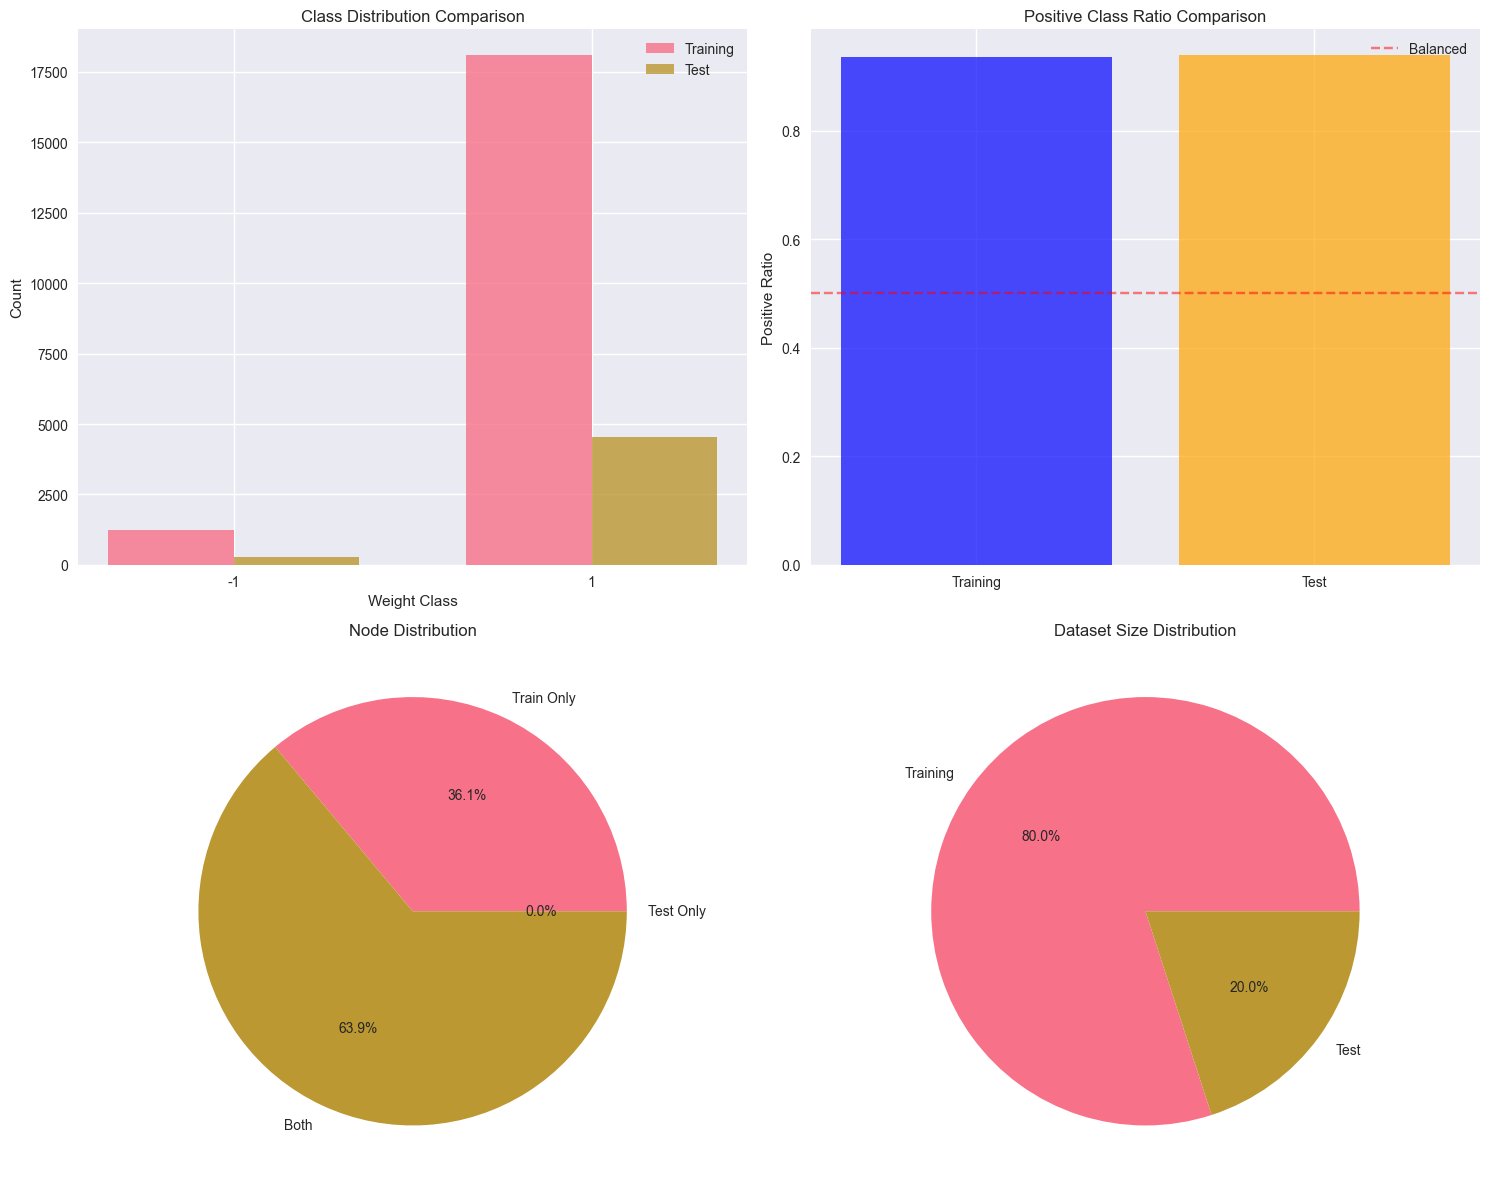

In [10]:
def compare_datasets(train_df, test_df):
    """Compare training and test datasets"""
    if train_df is None or test_df is None:
        print("Cannot compare datasets - one or both not loaded")
        return
    
    print("\n=== Training vs Test Set Comparison ===")
    
    # Basic statistics comparison
    comparison_stats = pd.DataFrame({
        'Training': [
            len(train_df),
            len(set(train_df['source']).union(set(train_df['target']))),
            train_df['weight'].mean(),
            (train_df['weight'] > 0).mean(),
        ],
        'Test': [
            len(test_df),
            len(set(test_df['source']).union(set(test_df['target']))),
            test_df['weight'].mean(),
            (test_df['weight'] > 0).mean(),
        ]
    }, index=['Edges', 'Nodes', 'Mean Weight', 'Positive Ratio'])
    
    print(comparison_stats)
    
    # Node overlap
    train_nodes = set(train_df['source']).union(set(train_df['target']))
    test_nodes = set(test_df['source']).union(set(test_df['target']))
    
    overlap = len(train_nodes & test_nodes)
    train_only = len(train_nodes - test_nodes)
    test_only = len(test_nodes - train_nodes)
    
    print(f"\nNode Overlap Analysis:")
    print(f"  Nodes in both sets: {overlap}")
    print(f"  Nodes only in train: {train_only}")
    print(f"  Nodes only in test: {test_only}")
    print(f"  Overlap ratio: {overlap / len(train_nodes | test_nodes):.4f}")
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Class distribution comparison
    train_class_dist = train_df['weight'].value_counts().sort_index()
    test_class_dist = test_df['weight'].value_counts().sort_index()
    
    x = np.arange(len(train_class_dist))
    width = 0.35
    
    axes[0,0].bar(x - width/2, train_class_dist.values, width, label='Training', alpha=0.8)
    axes[0,0].bar(x + width/2, test_class_dist.values, width, label='Test', alpha=0.8)
    axes[0,0].set_title('Class Distribution Comparison')
    axes[0,0].set_xlabel('Weight Class')
    axes[0,0].set_ylabel('Count')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(train_class_dist.index)
    axes[0,0].legend()
    
    # Positive ratio comparison
    pos_ratios = [comparison_stats.loc['Positive Ratio', 'Training'], 
                  comparison_stats.loc['Positive Ratio', 'Test']]
    axes[0,1].bar(['Training', 'Test'], pos_ratios, color=['blue', 'orange'], alpha=0.7)
    axes[0,1].set_title('Positive Class Ratio Comparison')
    axes[0,1].set_ylabel('Positive Ratio')
    axes[0,1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Balanced')
    axes[0,1].legend()
    
    # Node overlap visualization
    overlap_data = [train_only, overlap, test_only]
    labels = ['Train Only', 'Both', 'Test Only']
    axes[1,0].pie(overlap_data, labels=labels, autopct='%1.1f%%')
    axes[1,0].set_title('Node Distribution')
    
    # Dataset size comparison
    sizes = [comparison_stats.loc['Edges', 'Training'], 
             comparison_stats.loc['Edges', 'Test']]
    axes[1,1].pie(sizes, labels=['Training', 'Test'], autopct='%1.1f%%')
    axes[1,1].set_title('Dataset Size Distribution')
    
    plt.tight_layout()
    plt.show()
    
    return comparison_stats

# Compare datasets
comparison_results = compare_datasets(train_df, test_df)

## 7. Summary and Recommendations

In [11]:
def generate_summary_recommendations(train_df, test_df, train_class_dist, test_class_dist):
    """Generate summary and recommendations based on analysis"""
    print("\n" + "="*60)
    print("SUMMARY AND RECOMMENDATIONS")
    print("="*60)
    
    if train_class_dist is not None:
        # Calculate imbalance metrics
        if len(train_class_dist) == 2:
            majority_class = train_class_dist.max()
            minority_class = train_class_dist.min()
            imbalance_ratio = majority_class / minority_class
            positive_ratio = train_class_dist.get(1, 0) / train_class_dist.sum() if 1 in train_class_dist.index else 0
            
            print(f"\n📊 CLASS IMBALANCE ANALYSIS:")
            print(f"   • Imbalance Ratio: {imbalance_ratio:.2f}:1")
            print(f"   • Positive Class Ratio: {positive_ratio:.4f} ({positive_ratio*100:.2f}%)")
            
            # Determine severity
            if imbalance_ratio > 10:
                severity = "SEVERE"
                color = "🔴"
            elif imbalance_ratio > 5:
                severity = "MODERATE"
                color = "🟡"
            else:
                severity = "MILD"
                color = "🟢"
            
            print(f"   • Imbalance Severity: {color} {severity}")
            
            print(f"\n🎯 RECOMMENDED SOLUTIONS:")
            
            if imbalance_ratio > 5:
                print(f"   1. 📊 SAMPLING TECHNIQUES:")
                print(f"      • SMOTE (Synthetic Minority Oversampling)")
                print(f"      • Random undersampling of majority class")
                print(f"      • Combination of over/under sampling")
                
                print(f"\n   2. 🎛️ ALGORITHM MODIFICATIONS:")
                print(f"      • Class weights: {{0: 1.0, 1: {imbalance_ratio:.1f}}}")
                print(f"      • Focal Loss (γ=2, α={1-positive_ratio:.3f})")
                print(f"      • Cost-sensitive learning")
                
                print(f"\n   3. 📈 EVALUATION METRICS:")
                print(f"      • Use Precision, Recall, F1-score instead of Accuracy")
                print(f"      • Focus on AUC-ROC and AUC-PR")
                print(f"      • Confusion matrix analysis")
                print(f"      • Stratified cross-validation")
                
                print(f"\n   4. 🏗️ MODEL ARCHITECTURE:")
                print(f"      • Increase model complexity (more layers/dimensions)")
                print(f"      • Higher dropout for regularization")
                print(f"      • Ensemble methods")
                print(f"      • Attention mechanisms for better feature learning")
            
            print(f"\n⚙️ SPECIFIC HYPERPARAMETER SUGGESTIONS:")
            print(f"   • Node feature dim: 32-64 (currently 16)")
            print(f"   • Embedding dim: 32-64 (currently 16)")
            print(f"   • Number of heads: 8-16 (currently 4)")
            print(f"   • Number of layers: 3-4 (currently 2)")
            print(f"   • Dropout rate: 0.3-0.5 (currently 0.1)")
            print(f"   • Learning rate: 0.0001-0.0005 (currently 0.001)")
    
    print(f"\n" + "="*60)

# Generate summary
generate_summary_recommendations(train_df, test_df, train_class_dist, test_class_dist)


SUMMARY AND RECOMMENDATIONS

📊 CLASS IMBALANCE ANALYSIS:
   • Imbalance Ratio: 14.57:1
   • Positive Class Ratio: 0.9358 (93.58%)
   • Imbalance Severity: 🔴 SEVERE

🎯 RECOMMENDED SOLUTIONS:
   1. 📊 SAMPLING TECHNIQUES:
      • SMOTE (Synthetic Minority Oversampling)
      • Random undersampling of majority class
      • Combination of over/under sampling

   2. 🎛️ ALGORITHM MODIFICATIONS:
      • Class weights: {0: 1.0, 1: 14.6}
      • Focal Loss (γ=2, α=0.064)
      • Cost-sensitive learning

   3. 📈 EVALUATION METRICS:
      • Use Precision, Recall, F1-score instead of Accuracy
      • Focus on AUC-ROC and AUC-PR
      • Confusion matrix analysis
      • Stratified cross-validation

   4. 🏗️ MODEL ARCHITECTURE:
      • Increase model complexity (more layers/dimensions)
      • Higher dropout for regularization
      • Ensemble methods
      • Attention mechanisms for better feature learning

⚙️ SPECIFIC HYPERPARAMETER SUGGESTIONS:
   • Node feature dim: 32-64 (currently 16)
   • Em